# Exercise 1: Text Classification using CNNs, LSTMs and Bi-Directional LSTMs

Understanding the text content and predicting the sentiment of the reviews is a form of supervised machine learning. To be more specific, we will be using classification models for solving the problem of hate speech detection. We will be building an automated hate speech classification system in subsequent sections. The major steps to achieve this are mentioned as follows.

+ Prepare train and test datasets (optionally a validation dataset)
+ Pre-process and normalize text documents
+ Feature Engineering 
+ Model training
+ Model prediction and evaluation

These are the major steps for building our system. Optionally the last step would be to deploy the model in your server or on the cloud. 

We will build models using deep learning in the subsequent sections. Our focus will be on Convolutional Neural Networks and Long Short Term Memory (LSTM) Networks

## Load Dataset - Hate Speech

Social media unfortunately is rampant with hate speech in the form of posts and comments. This is a practical example of perhaps building an automated hate speech detection system using NLP in the form of text classification.

In this notebook, we will leverage an open sourced collection of hate speech posts and comments.

The dataset is available here: [kaggle](https://www.kaggle.com/usharengaraju/dynamically-generated-hate-speech-dataset) which in turn has been curated from a wider [data source for hate speech](https://hatespeechdata.com/)

In [2]:
!nvidia-smi

Mon Dec  6 10:45:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.11       Driver Version: 471.11       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 16%   42C    P8    22W / 175W |    914MiB /  8192MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Dependencies

In [3]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\New
[nltk_data]     User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Libraries

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

ModuleNotFoundError: No module named 'tensorflow'

## Load Dataset

In [ ]:
df = pd.read_csv('HateDataset.csv')
df.info()

In [ ]:
df = df[['text', 'label']]
df.head()

## Prepare Train-Test Splits

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_reviews, test_reviews, train_labels, test_labels = train_test_split(df.text.values,
                                                                          df.label.values,
                                                                          test_size=0.2, random_state=42)

In [ ]:
len(train_reviews), len(test_reviews)

## Text Preprocessing : Text Wrangling and Normalization

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, flags=re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

## Feature Engineering

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder

In [5]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

NameError: name 'Tokenizer' is not defined

In [6]:
# transform train set using the tokenizer
train_sequences = t.texts_to_sequences(norm_train_reviews)

NameError: name 't' is not defined

In [7]:
# transform test set using the tokenizer
test_sequences = t.texts_to_sequences(norm_test_reviews)

NameError: name 't' is not defined

In [8]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

NameError: name 't' is not defined

### Visualize Document Lengths

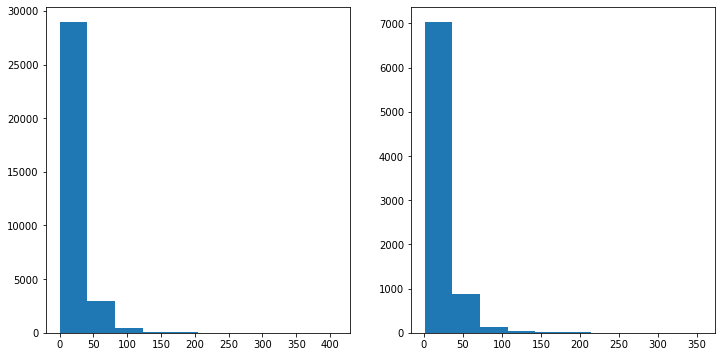

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [20]:
# while 250 is long should be a safe bet
MAX_SEQUENCE_LENGTH = 250

In [21]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((32498, 250), (8125, 250))

## Label Encode Class Labels

In [22]:
le = LabelEncoder()
# positive -> 1, negative -> 0
num_classes=2 

In [23]:
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

In [24]:
VOCAB_SIZE = len(t.word_index)

## **Question 1**:  Build and Train a CNN Model (4 points)

**Define** a Convolutional Neural Network such as it has:

+ An embedding layer with embedding size of 300
+ 3 pairs of Convolutional-1d and Maxpooling layer pairs
+ Dense layers 
+ Choose an appropriate loss function and activation function for the final layer

_Hint: Use a similar config as the tutorial and if you have more time feel free to play around with the layers and necessary hyperparameters_

In [25]:
EMBED_SIZE = 300
EPOCHS=10
BATCH_SIZE=128
model = Sequential()

model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))

model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 300)          6066300   
                                                                 
 conv1d (Conv1D)             (None, 250, 128)          153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 125, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 125, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 62, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 62, 32)            8

## Train the CNN Model

In [26]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          callbacks=[es], 
          verbose=1)

Epoch 1/10
229/229 [==============================] - 26s 53ms/step - loss: 0.5953 - accuracy: 0.6514 - val_loss: 0.5225 - val_accuracy: 0.7163
Epoch 2/10
229/229 [==============================] - 11s 49ms/step - loss: 0.3954 - accuracy: 0.8145 - val_loss: 0.4946 - val_accuracy: 0.7440
Epoch 3/10
229/229 [==============================] - 11s 48ms/step - loss: 0.2269 - accuracy: 0.9036 - val_loss: 0.6040 - val_accuracy: 0.7437
Epoch 4/10
229/229 [==============================] - 11s 48ms/step - loss: 0.1170 - accuracy: 0.9543 - val_loss: 0.7853 - val_accuracy: 0.7443
Epoch 00004: early stopping


## Evaluate CNN Model

In [1]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
y_pred = model.predict_classes(X_test).ravel()
predictions = le.inverse_transform(y_pred) 
predictions[:10]
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sequences, predictions))
pd.DataFrame(confusion_matrix(test_sequences, predictions), index=labels, columns=labels)

NameError: name 'model' is not defined

## **Question 2**: Build and Train a LSTM based Model (4 points)

### **Define** a LSTM based Neural Network such as it has:

+ An embedding layer with embedding size of 300
+ An LSTM layer
+ Dense layers 
+ Choose an appropriate loss function and activation function for the final layer

_Hint: Use a similar config as the tutorial and if you have more time feel free to play around with the layers and necessary hyperparameters_

In [28]:

EMBEDDING_DIM = 300
LSTM_DIM = 128
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                    output_dim=EMBEDDING_DIM, 
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.SpatialDropout1D(0.1))

model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))

model.add(tf.keras.layers.Dense(256, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 300)          6066300   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6,319,229
Trainable params: 6,319,229
Non-trainable params: 0
____________________________________________

## Train the model

In [29]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
229/229 [==============================] - 22s 82ms/step - loss: 0.5900 - accuracy: 0.6655 - val_loss: 0.5468 - val_accuracy: 0.7034
Epoch 2/10
229/229 [==============================] - 18s 79ms/step - loss: 0.4460 - accuracy: 0.7766 - val_loss: 0.5285 - val_accuracy: 0.7295
Epoch 3/10
229/229 [==============================] - 18s 79ms/step - loss: 0.3352 - accuracy: 0.8402 - val_loss: 0.6053 - val_accuracy: 0.7271
Epoch 4/10
229/229 [==============================] - 18s 78ms/step - loss: 0.2546 - accuracy: 0.8828 - val_loss: 0.6918 - val_accuracy: 0.7345
Epoch 00004: early stopping


## Evaluate the Model

In [30]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

254/254 [==============================] - 5s 20ms/step - loss: 0.5269 - accuracy: 0.7242
Accuracy: 72.42%


## **Question 3**: Build and Train a Bi-LSTM based Model (6 points)

### **Define** a Bi-Directional LSTM based Neural Network such as it has:

+ An embedding layer with embedding size of 300
+ 2 bi-directional LSTM layers (hint: remeber how to use ``return sequences``)
+ Dense and Dropout layers 
+ Choose an appropriate loss function and activation function for the final layer

_Hint: Use a similar config as the tutorial and if you have more time feel free to play around with the layers and necessary hyperparameters_

In [35]:
EMBEDDING_DIM = 300 
LSTM_DIM = 128 

inp = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))

x = tf.keras.layers.Embedding(VOCAB_SIZE, 
                              EMBEDDING_DIM, 
                              trainable=True)(inp)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, 
                                                       return_sequences=True),
                                  merge_mode='concat')(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM, 
                                                       return_sequences=False),
                                  merge_mode='concat')(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)

outp = tf.keras.layers.Dense(1, activation='sigmoid')(x)
# initialize the model
model3 = tf.keras.models.Model(inputs=inp, outputs=outp)

    
model3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), 
               metrics=['accuracy'])
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 250, 300)          6066300   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 256)         439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0     

## Train the Model

In [36]:
batch_size = 100
model3.fit(X_train, y_train, epochs=2, batch_size=batch_size, 
           shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/2
293/293 [==============================] - 89s 279ms/step - loss: 0.5922 - accuracy: 0.6585 - val_loss: 0.5513 - val_accuracy: 0.6994
Epoch 2/2
293/293 [==============================] - 80s 274ms/step - loss: 0.4432 - accuracy: 0.7790 - val_loss: 0.5335 - val_accuracy: 0.7237


## Evaluate the Model

In [37]:
scores = model3.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

254/254 [==============================] - 26s 104ms/step - loss: 0.5283 - accuracy: 0.7246
Accuracy: 72.46%


In [38]:
prediction_probs = model3.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

254/254 [==============================] - 25s 91ms/step


[0, 1, 1, 0, 0, 1, 0, 0, 1, 0]

In [39]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
labels = ['negative', 'positive']
print(classification_report(test_sequences, predictions))
pd.DataFrame(confusion_matrix(test_sequences, predictions), index=labels, columns=labels)

ValueError: ignored